# 介绍

此部分介绍特征工程部分，带你来了解各种特征工程以及分析方法。

**目的：**

- 学习特征预处理、缺失值、异常值处理、数据分桶等特征处理方法
- 学习特征交互、编码、选择的相应方法
- 完成相应学习打卡任务，两个选做的作业不做强制性要求，供学有余力同学自己探索

**主要内容：**

- 数据预处理：
  - 缺失值的填充
  - 时间格式处理
  - 对象类型特征转换到数值
- 异常值处理：
  - 基于3segama原则
  - 基于分位数原则
- 数据分箱
  - 固定宽度分箱
  - 分位数分箱
  - 卡方分箱（选做作业）
- 特征交互
- 特征编码
- 特征选择
    - 1 Filter
    - 2 Wrapper （RFE）
    - 3 Embedded
    
**文件说明：**

数据来源为“天池”的学习赛：*零基础入门金融风控-贷款违约预测*

以下代码主要参考该比赛的开源代码

比赛项目地址：https://tianchi.aliyun.com/competition/entrance/531830/forum

开源地址：https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12586969.1002.9.3b3022faSpZmD0&postId=129321

In [1]:
# 导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [2]:
# 读取经过EDA后的数据
data =pd.read_csv('Data/train_EDA.csv',index_col = 0)

# 特征预处理

In [3]:
# 在处理之前，我们需要对大概的数据有一个初步的观察。
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798823 entries, 0 to 799999
Data columns (total 46 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   798823 non-null  int64  
 1   loanAmnt             798823 non-null  float64
 2   term                 798823 non-null  int64  
 3   interestRate         798823 non-null  float64
 4   installment          798823 non-null  float64
 5   grade                798823 non-null  object 
 6   subGrade             798823 non-null  object 
 7   employmentTitle      798823 non-null  float64
 8   employmentLength     798823 non-null  object 
 9   homeOwnership        798823 non-null  int64  
 10  annualIncome         798823 non-null  float64
 11  verificationStatus   798823 non-null  int64  
 12  isDefault            798823 non-null  int64  
 13  purpose              798823 non-null  int64  
 14  postCode             798823 non-null  float64
 15  regionCode       

- 数据EDA部分我们已经对数据的大概和某些特征分布有了了解，并且做了一些预处理的工作，此处主要是查漏补缺

之前我们已经对缺失值、时间格式等特征进行了处理，所以这里观察到并没有缺失，两个时间格式的特征也被我们处理成为了数值类型。

但是数据集中仍然有`grade,subgrade,employmentLength`三个对象类型特征，需要对这类特征进行处理

同时，在EDA过程中我们知道，有许多数值型特征是离散型特征，这类特征也需要处理

**注意，在这里进行的处理方式只是一个简单的介绍，大概率不是最佳的，需要根据后续建模和实际需要对数据的处理进行调整**

In [5]:
# 首先我们查找出数据中的对象特征和数值型特征
numerical_fea = list(data.select_dtypes(exclude=['object']).columns)
category_fea = list(data.select_dtypes(include=['object']).columns)
label = 'isDefault' # isDefault 表示违约与否，是目标变量，不是特征
numerical_fea.remove(label)

## 对象类型特征处理

In [6]:
# 对employmentLength进行处理，这个特征表示客户的工作年限，我们之前用Other填充了缺失，这里为了使用其工作年限当作数值。用-1填充Other
def employmentLength_to_int(s):
    if s == 'Other':
        return -1
    else:
        return np.int8(s.split()[0])
data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [7]:
data['employmentLength'].value_counts(dropna=False).sort_index()

-1      46541
 0      64071
 1      52394
 2      72264
 3      64084
 4      47930
 5      50051
 6      37210
 7      35370
 8      36152
 9      30244
 10    262512
Name: employmentLength, dtype: int64

`subgrade`与`grade`都是信用等级，首先观察有什么区别

<AxesSubplot:>

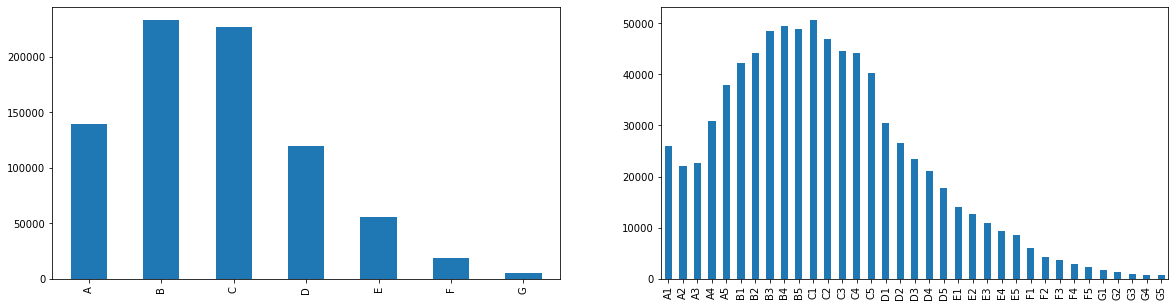

In [9]:
plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,2,1)
data['grade'].value_counts().sort_index().plot(kind = 'bar',ax = ax1)
ax2 = plt.subplot(1,2,2)
data['subGrade'].value_counts().sort_index().plot(kind = 'bar',ax = ax2)

可以看到grade的信息都在subGrade里面，因此grade与subGrade中，我们只需要保留subGrade就可以了。对于subGrade的处理可以进行OneHot编码

In [10]:
data.drop(columns = 'grade',inplace = True)

## 类别特征处理

In [11]:
# 部分类别特征
cate_features = ['subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

subGrade 类型数： 35
employmentTitle 类型数： 248264
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 932
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 39368


有些特征从物理含义上应该是分类特征，例如employmentTitle，但是这类特征的类别数特别多，并且已经进行了数值转换，我们无法提取出原始信息进行特征构造，因此将这类特征当作数值连续型变量。

In [10]:
# 类型数在2之上，维度不是特别大,且纯分类特征的进行OneHot编码
data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

# 异常值处理
- 当你发现异常值后，一定要先分清是什么原因导致的异常值，然后再考虑如何处理。
    - 如果这一异常值并不代表一种规律性的，而是极其偶然的现象，或者说你并不想研究这种偶然的现象，这时可以将其删除。
    - 如果异常值存在且代表了一种真实存在的现象，那就不能随便删除。在现有的欺诈场景中很多时候欺诈数据本身相对于正常数据勒说就是异常的，我们要把这些异常点纳入，重新拟合模型，研究其规律。能用监督的用监督模型，不能用的还可以考虑用异常检测的算法来做。

**有两种比较基础的异常值的检测办法：**

1. 三倍标准差法：在统计学中，如果一个数据分布近似正态，在均值三个标准差范围外的数据值可以当作异常值。
2. 四分位数法：对数据划分四分位数，超过上四分位1.5倍四分位距或低于下四分位1.5倍四分位距的数值被认为是异常值。

## 三倍标准差法

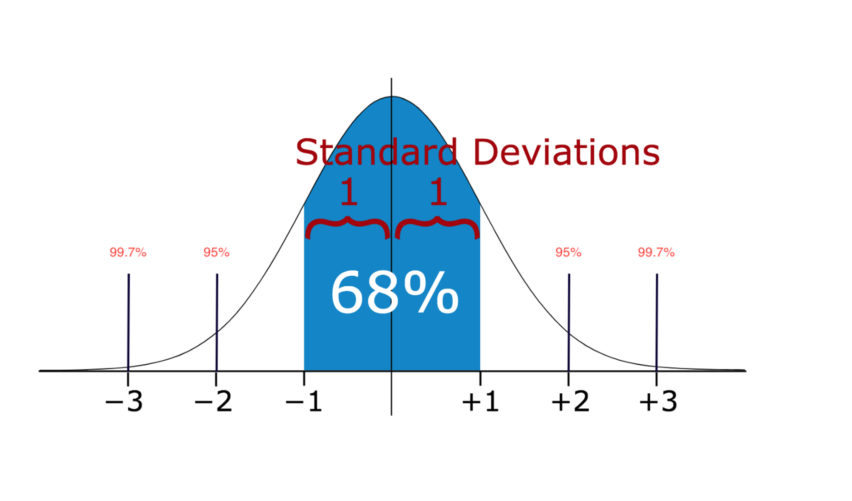

在上图中，如果一个数据服从正态分布，那么数据超过均值上下三倍标准差的概率为0.3%（单边概率），则可以认为是小概率事件，即异常值。

下面的代码说明了如何观察是否存在异常值

In [25]:
def find_outliers_by_3segama(data, fea):
    """
    根据3倍标准差的方法寻找异常值
    ---------------------------
    params：
    data：寻找异常值的数据
    fea：寻找异常值的特征名
    """
    mean = data[fea].mean()
    std = data[fea].std()
    up_limit = mean+3*std
    bottom_limit = mean-3*std
    print(f"正常值的范围：{round(bottom_limit,4),round(up_limit,4)}")
    print("是否存在超出正常范围的值：", any(data[fea] > up_limit))
    print("是否存在小于正常范围的值：", any(data[fea] < bottom_limit))

- 得到特征的异常值后可以进一步分析变量异常值和目标变量的关系

In [26]:
numerical_fea = list(data.select_dtypes(exclude=['object']).columns)

In [27]:
for fea in numerical_fea:
    print(f"{fea} 的异常值检查：")
    find_outliers_by_3segama(data,fea)
    print("-"*30)

id 的异常值检查：
正常值的范围：(-292846.6665, 1092817.0209)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
loanAmnt 的异常值检查：
正常值的范围：(-11724.1125, 40563.5989)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
term 的异常值检查：
正常值的范围：(0.9151, 6.0509)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
interestRate 的异常值检查：
正常值的范围：(-1.0592, 27.5354)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
installment 的异常值检查：
正常值的范围：(-346.2093, 1222.2518)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
employmentTitle 的异常值检查：
正常值的范围：(-247712.6497, 391601.9093)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
employmentLength 的异常值检查：
正常值的范围：(-6.2447, 17.366)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
homeOwnership 的异常值检查：
正常值的范围：(-1.4129, 2.6412)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
annualIncome 的异常值检查：
正常值的范围：(-130335.6784, 28262

## 四分位法

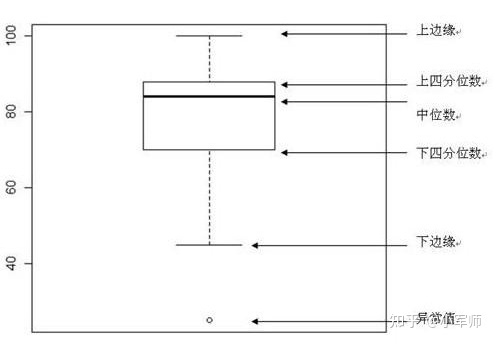

四分位距就是上四分位数到下四分位数的距离。

具体方法如下：其中Q3代表上四分位数，Q1代表下四分位数，k代表系数，可以取值1.5或3。

- 最大值估计= Q3+k（Q3-Q1)
- 最小值估计= Q1-k(Q3-Q1)

>当k=3时，代表极度异常值；

>当k=1.5时，代表中度异常值。

一般采用k=1.5

In [29]:
def find_outliers_by_quantile(data, fea):
    """
    根据分位数的方法寻找异常值
    ---------------------------
    params：
    data：寻找异常值的数据
    fea：寻找异常值的特征名
    """
    Q1 = data[fea].quantile(q=0.25)#下四分位差
    Q3 = data[fea].quantile(q=0.75)#上四分位差
    Q_distance = Q3-Q1#中位差
    up_limit = Q3+1.5*Q_distance
    bottom_limit = Q1-1.5*Q_distance
    print(f"正常值的范围：{round(bottom_limit,4),round(up_limit,4)}")
    print("是否存在超出正常范围的值：", any(data[fea] > up_limit))
    print("是否存在小于正常范围的值：", any(data[fea] < bottom_limit))

In [31]:
for fea in numerical_fea:
    print(f"{fea} 的异常值检查：")
    find_outliers_by_quantile(data,fea)
    print("-"*30)

id 的异常值检查：
正常值的范围：(-400030.5, 1200009.5)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
loanAmnt 的异常值检查：
正常值的范围：(-10000.0, 38000.0)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
term 的异常值检查：
正常值的范围：(3.0, 3.0)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
interestRate 的异常值检查：
正常值的范围：(0.39, 25.35)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
installment 的异常值检查：
正常值的范围：(-249.895, 1079.105)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
employmentTitle 的异常值检查：
正常值的范围：(-175066.25, 292915.75)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
employmentLength 的异常值检查：
正常值的范围：(-10.0, 22.0)
是否存在超出正常范围的值： False
是否存在小于正常范围的值： False
------------------------------
homeOwnership 的异常值检查：
正常值的范围：(-1.5, 2.5)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
------------------------------
annualIncome 的异常值检查：
正常值的范围：(-20965.0, 156579.0)
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False
--

>**请自行找资料思考存在异常值应该要怎么处理？**

# 数据分桶

- 特征分箱的目的：
  - 从模型效果上来看，特征分箱主要是为了降低变量的复杂性，减少变量噪音对模型的影响，提高自变量和因变量的相关度。从而使模型更加稳定。
- 数据分桶的对象：
  - 将连续变量离散化
  - 将多状态的离散变量合并成少状态
- 分箱的原因：
  - 数据的特征内的值跨度可能比较大，对有监督和无监督中如k-均值聚类它使用欧氏距离作为相似度函数来测量数据点之间的相似度。都会造成大吃小的影响，其中一种解决方法是对计数值进行区间量化即数据分桶也叫做数据分箱，然后使用量化后的结果。
- 分箱的优点：
  - 处理缺失值：当数据源可能存在缺失值，此时可以把null单独作为一个分箱。
  - 处理异常值：当数据中存在离群点时，可以把其通过分箱离散化处理，从而提高变量的鲁棒性（抗干扰能力）。例如，age若出现200这种异常值，可分入“age > 60”这个分箱里，排除影响。
  - 业务解释性：我们习惯于线性判断变量的作用，当x越来越大，y就越来越大。但实际x与y之间经常存在着非线性关系，此时可经过WOE变换。

- 特别要注意一下分箱的基本原则：
  - （1）最小分箱占比不低于5%
  - （2）箱内不能全部是好客户
  - （3）连续箱单调

## 固定宽度分箱 

- 当数值的数量级不大时，可以按照等距分箱，即0 ~ 1000、 1001 ~ 2000、 2001 ~ 3000等
- 当数值横跨多个数量级时，最好按照 10 的幂（或任何常数的幂）来进行分组：0 ~ 9、10 ~ 99、100 ~ 999、1000 ~ 9999，等等。

固定宽度分箱非常容易计算，但如果计数值中有比较大的缺口，就会产生很多没有任何数据的空箱子。

In [39]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [42]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

## 分位数分箱

分位数分箱是尽量使得每个箱子的数据大致一样，这样会尽量减少空箱子的数量，但是可能会改变数据的分布

In [47]:
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 5, labels=False)

In [41]:
data['loanAmnt_bin1'].value_counts().sort_index()

0.0         1
1.0     10694
2.0     16923
3.0     24505
4.0     26802
5.0     43616
6.0     42699
7.0     34173
8.0     43687
9.0     27726
10.0    72462
11.0    19594
12.0    54229
13.0    15701
14.0    23789
15.0    49447
16.0    30071
17.0    11891
18.0    24705
19.0    11103
20.0    47344
21.0    14779
22.0     9314
23.0     6058
24.0    23052
25.0    23408
26.0     4259
27.0     4401
28.0    13825
29.0     3084
30.0    18613
31.0     2107
32.0     4999
33.0     2379
34.0     1571
35.0    30423
36.0      901
37.0      181
38.0      208
39.0      110
40.0     3989
Name: loanAmnt_bin1, dtype: int64

In [43]:
data['loanAmnt_bin2'].value_counts().sort_index()

2.0         1
3.0    270825
4.0    527997
Name: loanAmnt_bin2, dtype: int64

In [48]:
data['loanAmnt_bin3'].value_counts().sort_index()

0    160820
1    168983
2    168378
3    142714
4    157928
Name: loanAmnt_bin3, dtype: int64

从上面三个分箱来看，等距分箱中存在过多箱子或箱子很少，需要人为更精细的调整，分位数分箱较为均匀，但是可能不符合原本的分布

## 其他分箱方法
 - 这一部分属于进阶部分，是实际中较为常用的方法（包括卡方分箱、WOE分箱等），可以自行搜索尝试。

# 特征交互
- 交互特征的构造非常简单，使用起来却代价不菲。如果线性模型中包含有交互特征对，那它的训练时间和评分时间就会从 $O(n)$ 增加到 $O(n^2)$，其中 n 是单一特征的数量。

In [53]:
# 衍生变量 mean 和 std
for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
    data['loanAmnt_to_mean_' + item] = data['loanAmnt'] / data.groupby([item])['loanAmnt'].transform('mean')
    data['loanAmnt_to_std_' + item] = data['loanAmnt'] / data.groupby([item])['loanAmnt'].transform('std')

这里给出了一个特征交互的思路，将n系列的各个特征与loanAmnt进行交互，上述的思路是在不同的n系列下的特征值下计算loanAmnt的均值,然后对原始的loanAmnt进行去中心化

这里只是进行特征交互的展示，这里构建的特征并不具备现实意义，但是实际应该根据现实意义进行特征构建，或者能够有效的提升模型效果，这需要专业的业务知识与不断的尝试，希望大家多多探索。

同时特征交互的方式也不止这一种方法，尝试其他的特征交互方法

# 特征编码


## labelEncode

In [65]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data[col].astype(str).values))
    data[col] = le.transform(list(data[col].astype(str).values))
print('Label Encoding 完成')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/it]

Label Encoding 完成


这里只是一个简单的特征编码，将所有的特征值从0开始进行编码。这样的做法非常简单，但是不一定是最有效的，而且可能存在一定的问题。

例如对postCode进行编码，postCode的含义是邮编地址。假如对‘A’邮编编码为1，对‘B’邮编编码为2，那么在线性模型中，‘B’邮编对目标变量的影响是‘A’的两倍，这很明显不符合逻辑。尽管在非线性模型中，这类影响会降低，但是这样仍然可能存在一定的问题。

**请大家查找资料，探索还有什么编码方式并实现（例如OneHot、WOE等）**

# 特征选择
- 特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。特征选择不是为了减少训练时间（实际上，一些技术会增加总体训练时间），而是为了减少模型评分时间。

特征选择的方法：

- 1 Filter
  - 方差选择法
  - 相关系数法（pearson 相关系数）
  - 卡方检验
  - 互信息法
- 2 Wrapper （RFE）
  - 递归特征消除法
- 3 Embedded
  - 基于惩罚项的特征选择法
  - 基于树模型的特征选择

## Filter
- 基于特征间的关系进行筛选

### 方差选择法
- 方差选择法中，先要计算各个特征的方差，然后根据设定的阈值，选择方差大于阈值的特征

In [67]:
train = data.drop(columns = ['isDefault']).copy()
target_train = data['isDefault'].copy()

In [101]:
train.fillna(train.mean(),inplace = True)

In [102]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值,方差小于该阈值的特征会被删除
vat = VarianceThreshold(threshold=3)
var_train = vat.fit_transform(train)

In [103]:
# 根据方差选择了以下特征
vat.get_feature_names_out(train.columns)

array(['id', 'loanAmnt', 'interestRate', 'installment', 'subGrade',
       'employmentTitle', 'employmentLength', 'annualIncome', 'purpose',
       'postCode', 'regionCode', 'dti', 'ficoRangeLow', 'ficoRangeHigh',
       'openAcc', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n1',
       'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n14',
       'issueDateDT', 'earliesCreditLineDT', 'loanAmnt_bin1'],
      dtype=object)

**这里只是做一个简单说明，其它的选择方法还包括卡方选择、相关系数选择、互信息选择等等许多其它选择方法，大家可以自行搜索资料并实现**

## Wrapper 
- 递归特征消除法（Recursive feature elimination，RFE） 递归消除特征法使用一个基模型来进行多轮训练，每轮训练后，消除若干权值系数的特征，再基于新的特征集进行下一轮训练。 在feature_selection库的RFE类可以用于选择特征，相关代码如下（以逻辑回归为例）：

In [125]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数

recuresive_fea = RFE(estimator=LogisticRegression(n_jobs = 4), n_features_to_select=30,step = 0.5)
rfe_train = recuresive_fea.fit_transform(train,target_train)

/root/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [126]:
recuresive_fea.get_feature_names_out(train.columns)

array(['loanAmnt', 'term', 'interestRate', 'installment', 'subGrade',
       'employmentLength', 'annualIncome', 'verificationStatus',
       'postCode', 'regionCode', 'dti', 'ficoRangeLow', 'ficoRangeHigh',
       'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2',
       'n3', 'n5', 'n6', 'n7', 'n8', 'n9', 'n14', 'issueDateDT',
       'earliesCreditLineDT', 'loanAmnt_bin2'], dtype=object)

## Embedded
- 基于惩罚项的特征选择法 使用带惩罚项的基模型，除了筛选出特征外，同时也进行了降维。 在feature_selection库的SelectFromModel类结合逻辑回归模型可以用于选择特征，相关代码如下：


In [137]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#带L1惩罚项的逻辑回归作为基模型的特征选择
embed_fea = SelectFromModel(LogisticRegression(penalty="l1", C=0.1,solver='saga'))

embed_train = embed_fea.fit_transform(train,target_train)

In [138]:
embed_fea.get_feature_names_out(train.columns)

array(['loanAmnt', 'ficoRangeLow', 'ficoRangeHigh', 'issueDateDT',
       'earliesCreditLineDT'], dtype=object)

- 除了逻辑回归以外还可以基于树模型的特征选择 在feature_selection库的SelectFromModel类结合GBDT模型可以用于选择特征，相关代码如下：

In [139]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
#GBDT作为基模型的特征选择

embed_GBDT_fea = SelectFromModel(GradientBoostingClassifier())
embed_train = embed_GBDT_fea.fit_transform(train,target_train)

In [140]:
embed_GBDT_fea.get_feature_names_out(train.columns)

array(['term', 'subGrade', 'employmentLength', 'homeOwnership',
       'annualIncome', 'dti', 'issueDateDT'], dtype=object)

可以看到根据不同的模型选择的特征不一样，因此需要根据自己的数据、模型和实际情况进行分析。

# 总结

特征工程是机器学习，甚至是深度学习中最为重要的一部分，在实际应用中往往也是所花费时间最多的一步。各种算法书中对特征工程部分的讲解往往少得可怜，因为特征工程和具体的数据结合的太紧密，很难系统地覆盖所有场景。

这里也只是简单介绍了一些主要的、基本的方法，除了这里的介绍以外还有很多的方法需要大家自行学习。在特征工程中比赛和具体的应用还是有所不同的，在实际的金融风控评分卡制作过程中，由于强调特征的可解释性，特征分箱尤其重要。但是如果在比赛中，最终只考察分数的大小，因此不看重可解释性，因此实际业务中需要更详细的、更贴合实际的特征工程。